In [1]:
import sys
sys.path.insert(0, '../../../')

# Base packages
import numpy as np
import matplotlib.pyplot as plt
import skimage
import scipy
from scipy import ndimage as ndi
import matplotlib.colors
import cv2

# Included in anaconda
import glob
import os

# External packages
from moviepy.editor import *
import hyperspy.api as hs
from tqdm import tqdm
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
from temnn.knet import MSDnet, Unet
from temnn.data.mods import local_normalize
from stm.feature.peaks import find_local_peaks

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 22})

# Specify GPU for Network Predictions

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Functions

We will be working with hyperspy objects to make use of their many functionalities.

In [3]:
def to_hs(im_array,im_ref):
    '''
    Function to convert a numpy array (im_array) into a hyperspy object 
    and set scale equal to that of a previously defined hyperspy object (im_ref)
    
    Returns a calibrated hyperspy object im_cal
    '''
    im_cal=hs.signals.Signal2D(im_array)
    
    im_cal.axes_manager.signal_axes[0].scale=im_ref.axes_manager.signal_axes[0].scale
    im_cal.axes_manager.signal_axes[1].scale=im_ref.axes_manager.signal_axes[1].scale

    im_cal.axes_manager.signal_axes[0].units=im_ref.axes_manager.signal_axes[0].units
    im_cal.axes_manager.signal_axes[1].units=im_ref.axes_manager.signal_axes[1].units
    
    return im_cal

We will likely be calculating the dose a few times I've put it into a function, docstring below should explain it

In [4]:
def compute_dose_rate(
    intensity,brightness,
    area,exposure):
    '''
    Function to compute dose given intensity integrated over an area
    Brightness calibration and exposure time required
    
    Return dose in units of electrons per angstrom^2 per second
    '''
    dose_rate=(intensity*brightness_cal)/(area*exposure)/100
    
    return dose_rate

# Load data

In [5]:
folder='../../experimental_data/dankelly/20211202_mos2_mltem2'
#doserate='DR1_AuNP1_ADC'
files=glob.glob(f'{folder}/*.dm4')
#files=glob.glob(r'{}/{}/Hour_00/Minute_*/Second_*/*.dm4'.format(folder,doserate))
# We can output the filenames gathered by glob to make sure they are correct
files

['../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0043.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0001.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0042.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0002.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0044.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0003.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0045.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0004.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0050.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0005.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0051.dm4',
 '../../experimental_data/dankelly/20211202_mos2_mltem2/mech_exf_mos2_0006.dm4',
 '../../experimental_data/da

In [6]:
#i = hs.load(files, lazy=True, stack=True)

In [7]:
output_dir='{}/MoS2_atomic_processing_output'.format(folder)
# Check if an output folder exists first, if not then creates one (will only create one the first time for a new dataset)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [8]:
# Saving the whole stack as a hyperspy object in this new output folder (you could do this as a tif or hdf5)
# This is smaller than the combination of all the dm4 files
#i.save('{}/stack_{}.hspy'.format(output_dir,doserate),overwrite=True)

In [10]:
# Now I can load the hyperspy file rather than use the lazy-loaded individual files
d = hs.load(files[0])
images = d.data
images.shape

(4086, 4089)

In [11]:
# This is because we loaded the data as a stack. The stack metadata has each individual frame's metadata
# The original data is in a 'DictionaryTree' but we want to loop through it
# So I am converting it to a standard Python dictionary
#stack_metadata=i.original_metadata.stack_elements.as_dictionary()

# An individual frame's metadata is then:
#frame_index=0
#frame_metadata=stack_metadata['element{}'.format(frame_index)]
frame_metadata = d.metadata.as_dictionary()

In [12]:
frame_metadata

{'_HyperSpy': {'Folding': {'unfolded': False,
   'signal_unfolded': False,
   'original_shape': None,
   'original_axes_manager': None}},
 'General': {'title': 'mech_exf_mos2_0043',
  'original_filename': 'mech_exf_mos2_0043.dm4',
  'date': '2021-12-02',
  'time': '14:18:51',
  'authors': 'wibang'},
 'Signal': {'binned': False,
  'signal_type': '',
  'quantity': 'Electrons (Counts)',
  'Noise_properties': {'Variance_linear_model': {'gain_factor': 0.02894151583313942,
    'gain_offset': 0.0}}},
 'Acquisition_instrument': {'TEM': {'beam_energy': 300.0,
   'Stage': {'tilt_alpha': -24.770397877993314,
    'x': -0.118164,
    'y': 0.0449257,
    'z': -0.13475299999999998},
   'acquisition_mode': 'TEM',
   'beam_current': 0.0,
   'magnification': 1400000.0,
   'microscope': 'ETEM OneView',
   'Camera': {'exposure': 2.0}}},
 'Sample': {'description': 'AuCeO2'}}

In [ ]:
#i.axes_manager.navigation_axes[0].scale=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageTags']['DataBar']['Exposure Time (s)']
#i.axes_manager.navigation_axes[0].units='s'
#i.axes_manager.navigation_axes[0].name='t'
#i.axes_manager

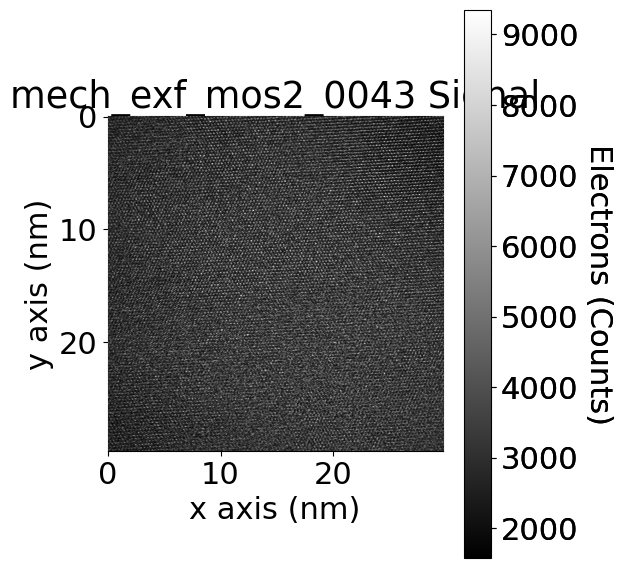

In [13]:
d.plot(navigator='slider')
plt.show()

In [15]:
x_cal,y_cal=d.axes_manager.signal_axes[0].scale,d.axes_manager.signal_axes[1].scale
x_size,y_size=d.axes_manager.signal_axes[0].size,d.axes_manager.signal_axes[1].size

x_nm,y_nm=x_cal*x_size,y_cal*y_size

# Calculate dose rates

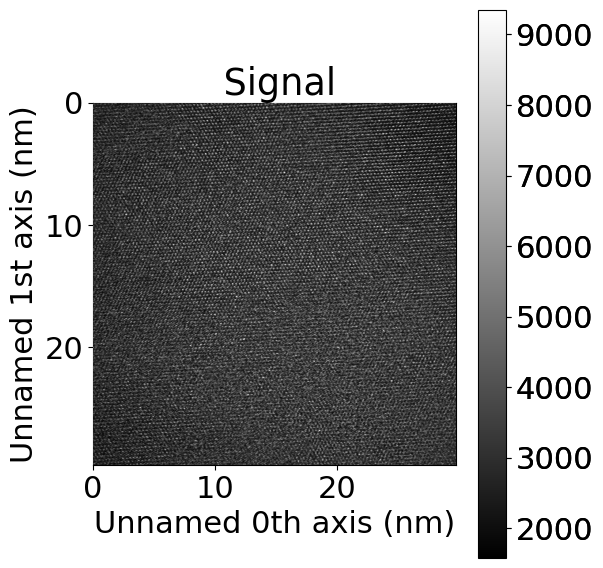

In [16]:
im=to_hs(d.data,d)
im.plot(navigator='slider')

plt.show()

In [17]:
brightness_cal=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageData']['Calibrations']['Brightness']['Scale']
exposure=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageTags']['DataBar']['Exposure Time (s)']

KeyError: 'original_metadata'

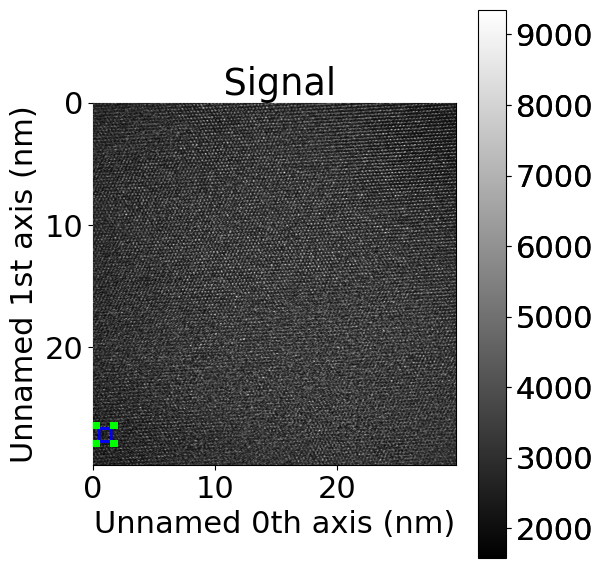

In [18]:
# You can play around with these values and shift it wherever you want, you can even drag it around on the plot
rect=hs.roi.RectangularROI(left=0.5,right=1.5,top=y_nm-3, bottom=y_nm-2) 

im.plot(navigator='slider')
roi=rect.interactive(im, color="blue")
plt.show()

In [ ]:
roi_data=roi.data
dose_rate_list=[]
area=roi.inav[0].data.shape[0]*roi.inav[0].data.shape[1]*(x_cal*y_cal)

for n in tqdm(range(0,roi_data.shape[0])):
    dose_rate_list.append(compute_dose_rate(roi_data[n].sum(),brightness_cal,area,exposure))
dose_rates=np.array(dose_rate_list)

In [ ]:
fig,ax=plt.subplots(figsize=(9.0,4.0))
ax.scatter(np.arange(0,len(dose_rates)*exposure,exposure),dose_rates,color='b',marker='s',s=7)
ax.hlines(np.mean(dose_rates[:]),xmin=0*exposure,xmax=len(dose_rates)*exposure,color='b',linestyle='dashed',alpha=0.5)

ax.set_xlabel('time (s)')
ax.set_ylabel('dose rate (e$^-$/$\AA^2$ s)')

plt.show()

In [ ]:
doses=dose_rates*exposure

# Load Neural Network for image predictions

In [ ]:
### Load trained neural network
n = 'MSDnet'
network = 'Au_fcc_mixed_atomic_negfoc'
nnf = '../../{}_precomputed_trained_data/{}'.format(n,network) #Trained Neural net folder
nnf = glob.glob(os.path.join(nnf,'model-*'))[-1] # latest model
print("Using {} CNN model in".format(n), network)

mod = keras.models.load_model(nnf)

# Analysis

Below I will work with a random example specified by 'frame_index' to test the result and formatting before running the loop over all frames

In [ ]:
def expand_mask(mask, radius=10):
    expand = mask.copy()
    for j in range(radius,mask.shape[1]):
        for k in range(radius,mask.shape[2]):
            window = mask[0,j-radius:j+radius,k-radius:k+radius]
            fraction = np.count_nonzero(window == 1.0)/(window.shape[0]*window.shape[1])
            if fraction > 0.1:
                expand[0,j,k] = 1.0
    return expand

def crop_nanoparticle(img, infer):
    # Make the inference mask binary
    binary = infer[:,:,:,0].copy()
    binary[binary > 0.01] = 1.0
    
    # Expand the inference mask
    crop = expand_mask(binary)
    blur_level=200
    crop = cv2.blur(crop[0,:,:], (blur_level, blur_level))
    crop = crop.reshape((1,)+crop.shape+(1,))
    
    # Crop out nanoparticle
    img_crop = img*crop
    return img_crop, crop

def crop_substrate(img, infer):
    # Make the inference mask binary
    binary = infer[:,:,:,1].copy()
    binary[binary > 0.01] = 1.0
    
    # Expand the inference mask
    crop = expand_mask(binary)
    blur_level=200
    crop = cv2.blur(crop[0,:,:], (blur_level, blur_level))
    crop = crop.reshape((1,)+crop.shape+(1,))
    
    # Crop out nanoparticle
    img_crop = img*crop
    return img_crop, crop

def cover_nanoparticle(img, infer):
    # Make the inference mask binary
    binary = infer.copy()
    binary[binary > 0.01] = 1.0
    
    # Expand the inference mask
    crop = expand_mask(binary,radius=100)
    crop = skimage.util.invert(crop[0,:,:,0])
    blur_level=200
    crop = cv2.blur(crop, (blur_level, blur_level))
    crop = crop.reshape((1,)+crop.shape+(1,))
    
    # Crop out nanoparticle
    img_crop = img*crop
    return img_crop, crop

def trim_imagescale(img, percent=1):
    sorted_pixels = sorted(img.flatten())
    n = len(sorted_pixels)
    trim = int(n*percent/100)
    return sorted_pixels[trim: n-trim]

def fft(img):
    f = np.fft.fft2(img)
    f = np.fft.fftshift(f)
    cf = f.shape[0]/2,f.shape[1]/2
    f = f[int(cf[0]-80):int(cf[0]+80),int(cf[1]-80):int(cf[1]+80)]
    return np.log(1+np.abs(f)) #np.abs(f), np.abs(np.log(f))

In [ ]:
frame_index=0#roi_data.shape[0]-1

frame_dose_rate=dose_rates[frame_index]
frame_dose=doses[frame_index]
frame_cumulative_dose=np.sum(doses[0:frame_index+1])
frame_time=np.round(exposure*(frame_index+1),2)

sampling = (i.axes_manager.signal_axes[0].scale)*10
normalizerange = 12.0/sampling
img = local_normalize(im.data[frame_index], normalizerange, normalizerange)
img.shape = (1,) + img.shape + (1,)
infer = mod.predict(img)

# Scale image distribution

To avoid dead/burning pixels shifting the contrast of the images displayed later I will scale every image remove the upper and lower 1% of the pixel value distribution. Here I visualise the cut.

In [ ]:
trimmed_pixels = trim_imagescale(img)            # Trim away the upper and lower 1% (default)
scale = min(trimmed_pixels), max(trimmed_pixels) # Save the values to scale

fig,ax=plt.subplots(figsize=(20.0,5.0),nrows=1,ncols=2)
ax[0].hist(img.flatten(),bins=100)
ax[1].hist(trimmed_pixels,bins=100)
plt.show()

# Plot everything

In [ ]:
plt.imshow(infer[0,:,:,0])
plt.show()

In [ ]:
## Processing
peaks = []
for p in range(infer.shape[-1]):
    peaks.append(find_local_peaks(infer[0,:,:,p],
                                   1,
                                   threshold=0.5,
                                   local_threshold=0,
                                   exclude_border=0,
                                   exclude_adjacent=True))

## Plotting
fig,ax=plt.subplots(figsize=(20.0,10.0),nrows=1,ncols=2)
ax[0].imshow(img[0,:,:,:],cmap='gray',vmin=scale[0],vmax=scale[1])
ax[0].set_title("Image w/ Inference Peaks",fontsize=32)

ax[0].text(x=0.075,y=0.96,s=r'Time : {} s'.format(frame_time),
        color='k',fontsize=32,transform=plt.gcf().transFigure)
ax[0].text(x=0.075,y=0.91,s=r'Dose rate: {} e$^-$/$\AA^2$ s'.format(np.format_float_scientific(frame_dose_rate,2)),
        color='k',fontsize=32,transform=plt.gcf().transFigure)
ax[0].text(x=0.075,y=0.10,s=r'Frame size: {} nm $\times$ {} nm'.format(np.round(x_nm,2),np.round(y_nm,2))
        ,fontsize=32,transform=plt.gcf().transFigure)
ax[0].text(x=0.075,y=0.05,s=r'Frame dose: {} e$^-$/$\AA^2$'.format(np.format_float_scientific(frame_dose,2)),
        color='k',fontsize=32,transform=plt.gcf().transFigure)
ax[0].text(x=0.075,y=0.0,s=r'Cumulative dose: {} e$^-$/$\AA^2$'.format(np.format_float_scientific(frame_cumulative_dose,2)),
        color='k',fontsize=32,transform=plt.gcf().transFigure)

ax[0].scatter(peaks[0][:,1],peaks[0][:,0],c='y')
ax[0].add_artist(ScaleBar(x_cal,units='nm',length_fraction=0.5,color='k',frameon=True,location='lower left'))
ax[0].set_xticks([])
ax[0].set_yticks([])

for n in np.arange(0,len(dose_rates[:frame_index+1])):
        ax[1].scatter((n+1)*exposure,dose_rates[n],
                      color='b',
                      marker='s',
                      s=25)
ax[1].hlines(np.mean(dose_rates[:]), 
             xmin=exposure,
             xmax=len(dose_rates)*exposure,
             color='b',
             linestyle='dashed',
             linewidth=5,
             alpha=0.5)

ax[1].set_xlim(0-5,len(im)*exposure+5)
ax[1].set_ylim(np.min(dose_rates),np.max(dose_rates))
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('dose rate (e$^-$/$\AA^2$ s)')

plt.tight_layout()
plt.show()

## Loop over all frames and generate each frame

In [ ]:
for frame_index in range(0,len(im)):
    print(frame_index)
    
    frame_dose_rate=dose_rates[frame_index]
    frame_dose=doses[frame_index]
    frame_cumulative_dose=np.sum(doses[0:frame_index+1])
    frame_time=np.round(exposure*(frame_index+1),2)

    normalizerange = 12.0/((i.axes_manager.signal_axes[0].scale)*10)
    img = local_normalize(im.data[frame_index], normalizerange, normalizerange)
    img.shape = (1,) + img.shape + (1,)
    infer = mod.predict(img)

    ## Processing
    peaks = []
    for p in range(infer.shape[-1]):
        peaks.append(find_local_peaks(infer[0,:,:,p],
                                       1,
                                       threshold=0.5,
                                       local_threshold=0,
                                       exclude_border=0,
                                       exclude_adjacent=True))

    ## Plotting
    fig,ax=plt.subplots(figsize=(20.0,10.0),nrows=1,ncols=2)
    ax[0].imshow(img[0,:,:,:],cmap='gray',vmin=scale[0],vmax=scale[1])
    ax[0].set_title("Image w/ Inference Peaks",fontsize=32)

    ax[0].text(x=0.075,y=0.96,s=r'Time : {} s'.format(frame_time),
            color='k',fontsize=32,transform=plt.gcf().transFigure)
    ax[0].text(x=0.075,y=0.91,s=r'Dose rate: {} e$^-$/$\AA^2$ s'.format(np.format_float_scientific(frame_dose_rate,2)),
            color='k',fontsize=32,transform=plt.gcf().transFigure)
    ax[0].text(x=0.075,y=0.10,s=r'Frame size: {} nm $\times$ {} nm'.format(np.round(x_nm,2),np.round(y_nm,2))
            ,fontsize=32,transform=plt.gcf().transFigure)
    ax[0].text(x=0.075,y=0.05,s=r'Frame dose: {} e$^-$/$\AA^2$'.format(np.format_float_scientific(frame_dose,2)),
            color='k',fontsize=32,transform=plt.gcf().transFigure)
    ax[0].text(x=0.075,y=0.0,s=r'Cumulative dose: {} e$^-$/$\AA^2$'.format(np.format_float_scientific(frame_cumulative_dose,2)),
            color='k',fontsize=32,transform=plt.gcf().transFigure)

    ax[0].scatter(peaks[0][:,1],peaks[0][:,0],c='y')
    ax[0].add_artist(ScaleBar(x_cal,units='nm',length_fraction=0.5,color='k',frameon=True,location='lower left'))
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    for n in np.arange(0,len(dose_rates[:frame_index+1])):
            ax[1].scatter((n+1)*exposure,dose_rates[n],
                          color='b',
                          marker='s',
                          s=25)
    ax[1].hlines(np.mean(dose_rates[:]), 
                 xmin=exposure,
                 xmax=len(dose_rates)*exposure,
                 color='b',
                 linestyle='dashed',
                 linewidth=5,
                 alpha=0.5)

    ax[1].set_xlim(0-5,len(im)*exposure+5)
    ax[1].set_ylim(np.min(dose_rates),np.max(dose_rates))
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('dose rate (e$^-$/$\AA^2$ s)')

    plt.tight_layout()
    
    plt.savefig('{}/scan_{}_{}.png'.format(output_dir,doserate,str(frame_index).zfill(3)))
    plt.close()

## Combine each frame to a movie

In [ ]:
individual_frames=glob.glob('{}/scan*.png'.format(output_dir),)
clips = [ImageClip(fr).set_duration((0,0,exposure)) for fr in individual_frames]
#concat_clip = concatenate_videoclips(clips, method="compose", bg_color=(1.0,1.0,1.0))
concat_clip = concatenate_videoclips(clips)

In [ ]:
concat_clip.write_videofile('{}/scan_video_{}.mp4'.format(output_dir,doserate),fps=1/exposure)
#concat_clip.write_gif('{}/scan_video_{}.gif'.format(output_dir,doserate),fps=1/exposure)